In [1]:
import cPickle

# PARAMS
log_dir = "/home/sforesti/avakas/scratch/sforestier001/logs/CogSci2017/2017-01-17_19-32-17-EXPLO-0.5"


filename = log_dir + '/results/competence.pickle'
with open(filename, 'r') as f:
    data_competence = cPickle.load(f)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

config_list = ["RMB"]
n_trial = 100
n_goals = 100
trial_list = range(1,n_trial + 1) 
config_name = "RMB"


In [3]:
bins = 100

map_comp = np.zeros((bins, bins))
map_hand = np.zeros((bins, bins))
map_tool = np.zeros((bins, bins))
map_vocal = np.zeros((bins, bins))

min_2d = [-1.,  -1.]
max_2d = [1.,  1.]

def real2map(x, y):
    i = int((x - min_2d[0]) / (max_2d[0] - min_2d[0]) * 100.)
    j = int((y - min_2d[0]) / (max_2d[0] - min_2d[0]) * 100.)
    i = max(0, min(i, 99))
    j = max(0, min(j, 99))
    return i, j

#trial_list = [1]
for trial in trial_list:
    for region in [1, 2, 3]:
        for gi in range(n_goals):
            for toy in ["toy1", "toy2", "toy3"]:
                x, y = data_competence[config_name][trial]["eval_results"][region][gi][toy]["toy_pos"]
                i, j = real2map(x, y)
                map_comp[i, j] += data_competence[config_name][trial]["eval_results"][region][gi][toy]["comp_error"]
                if data_competence[config_name][trial]["eval_results"][region][gi][toy]["arm_dist"] < data_competence[config_name][trial]["eval_results"][region][gi][toy]["diva_dist"]:
                    if data_competence[config_name][trial]["eval_results"][region][gi][toy]["tool"]:
                        map_tool[i, j] += 1
                    else:
                        map_hand[i, j] += 1
                else:      
                    map_vocal[i, j] += 1
        
for i in range(bins):
    for j in range(bins):
        n = map_hand[i, j] + map_tool[i, j] + map_vocal[i, j]
        if n > 0:
            map_comp[i, j] /= n
        else:
            map_comp[i, j] = -1
    
map_total = map_hand + map_tool + map_vocal

for i in range(bins):
    for j in range(bins):
        if map_total[i, j]:
            map_hand[i, j] /= map_total[i, j]
            map_tool[i, j] /= map_total[i, j]
            map_vocal[i, j] /= map_total[i, j]
        if (i - bins/2.)**2. + (j - bins/2.)**2. > bins*bins/4.:
            map_hand[i, j] = -1
            map_tool[i, j] = -1
            map_vocal[i, j] = -1
            

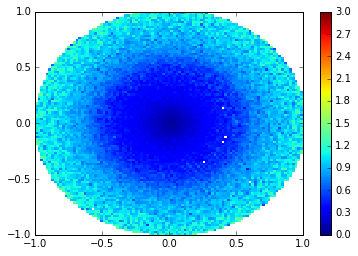

In [4]:

x_points = np.linspace(-1., 1., bins)
y_points = np.linspace(-1., 1., bins)

pcol = plt.pcolormesh(x_points, y_points, map_comp, vmin=0, vmax=3., linewidth=0, cmap="jet")  
pcol.set_rasterized(True)      
pcol.set_edgecolor('face')

pcol.cmap.set_under('white')

cb = plt.colorbar()
#cb.ax.set_yticklabels(["Tool", "", "", "", "", "", "", "", "", "", "Hand"], fontsize = 30)
cb.solids.set_rasterized(True)
cb.solids.set_edgecolor("face")

/usr/lib/python2.7/dist-packages/matplotlib/colors.py:581: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


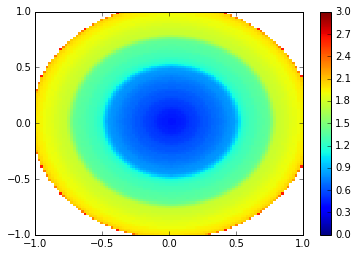

In [5]:
# GET MOTOR BABBLING ERROR MAP
import cPickle

filename = '../data/motor_babbling.pickle'
with open(filename, 'r') as f:
    map_comp_mb_avg = cPickle.load(f)
f.close()

pcol = plt.pcolormesh(x_points, y_points, map_comp_mb_avg, vmin=0, vmax=3., linewidth=0, cmap="jet")  
pcol.set_rasterized(True)      
pcol.set_edgecolor('face')

pcol.cmap.set_under('white')

cb = plt.colorbar()
#cb.ax.set_yticklabels(["Tool", "", "", "", "", "", "", "", "", "", "Hand"], fontsize = 30)
cb.solids.set_rasterized(True)
cb.solids.set_edgecolor("face")

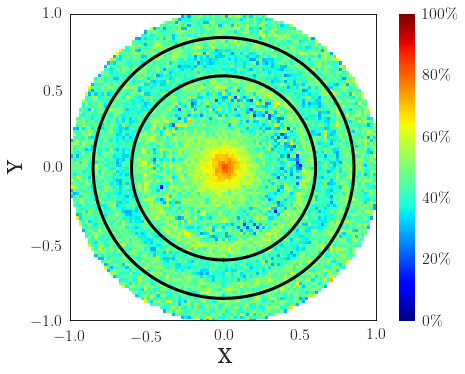

In [17]:
# NORMALIZE COMPETENCE MAP WITH MOTOR BABBLING MAP
map_comp_norm = np.zeros((bins, bins))

for i in range(bins):
    for j in range(bins):
        if map_comp[i, j] < 0.:
            map_comp_norm[i, j] = -1.
        elif np.isnan(map_comp_mb_avg[i, j]):
            map_comp_norm[i, j] = 200.
        else:
            map_comp_norm[i, j] = max(0., 1. - map_comp[i, j] / map_comp_mb_avg[i, j])

# the few missing points become avg of neighbors
for i in range(bins):
    for j in range(bins):
        if map_comp_norm[i, j] == -1. and (i-bins/2.) * (i-bins/2.) + (j-bins/2.) * (j-bins/2.) < bins * bins / 4.:
            map_comp_norm[i, j] = np.mean([map_comp_norm[i+1, j],
                                         map_comp_norm[i-1, j],
                                         map_comp_norm[i, j+1],
                                         map_comp_norm[i, j-1]])
        
x_points = np.linspace(-1., 1., bins)
y_points = np.linspace(-1., 1., bins)



import seaborn as sns
import numpy as np


plt.rc('text', usetex=True)
plt.rc('font', family='serif')

pcol = plt.pcolormesh(x_points, y_points, 100.* map_comp_norm, vmin=0., vmax=100., linewidth=0, cmap="jet")  
pcol.set_rasterized(True)      
pcol.set_edgecolor('face')
pcol.cmap.set_under('white')
pcol.cmap.set_over('grey')

cb = plt.colorbar()
cb.ax.set_yticklabels(["$0\%$", "", "$20\%$", "", "$40\%$", "", "$60\%$", "", "$80\%$", "", "$100\%$"], fontsize = 16)
cb.solids.set_rasterized(True)
cb.solids.set_edgecolor("face")   

ax = plt.axes()
ax.set_aspect(1)
theta = np.linspace(-np.pi, np.pi, 200)
plt.plot(0.6 * np.sin(theta), 0.6 * np.cos(theta), 'k', lw=3)
plt.plot(0.85 * np.sin(theta), 0.85 * np.cos(theta), 'k', lw=3)


plt.xlabel("X", fontsize=20)
plt.ylabel("Y", fontsize=20)

plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

plt.axhline(-1, color='k')
plt.axvline(-1, color='k')
plt.axhline(1, color='k')
plt.axvline(1, color='k')

plt.savefig('../figs/fig_competence.pdf', format='pdf', bbox_inches='tight')

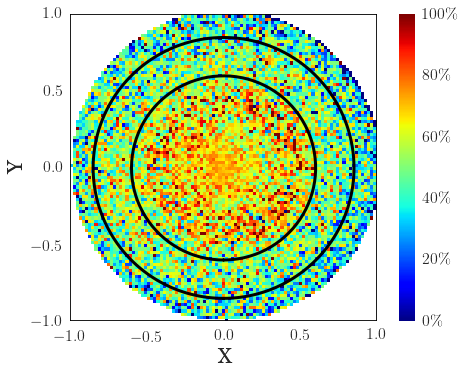

In [18]:
pcol = plt.pcolormesh(x_points, y_points, 100.* map_hand, vmin=0., vmax=100., linewidth=0, cmap="jet")  
pcol.set_rasterized(True)      
pcol.set_edgecolor('face')
pcol.cmap.set_under('white')
pcol.cmap.set_over('white')

cb = plt.colorbar()
cb.ax.set_yticklabels(["$0\%$", "", "$20\%$", "", "$40\%$", "", "$60\%$", "", "$80\%$", "", "$100\%$"], fontsize = 16)
cb.solids.set_rasterized(True)
cb.solids.set_edgecolor("face")   

ax = plt.axes()
ax.set_aspect(1)
theta = np.linspace(-np.pi, np.pi, 200)
plt.plot(0.6 * np.sin(theta), 0.6 * np.cos(theta), 'k', lw=3)
plt.plot(0.85 * np.sin(theta), 0.85 * np.cos(theta), 'k', lw=3)


plt.xlabel("X", fontsize=20)
plt.ylabel("Y", fontsize=20)

plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

plt.axhline(-1, color='k')
plt.axvline(-1, color='k')
plt.axhline(1, color='k')
plt.axvline(1, color='k')

plt.savefig('../figs/fig_strategy_hand.pdf', format='pdf', bbox_inches='tight')

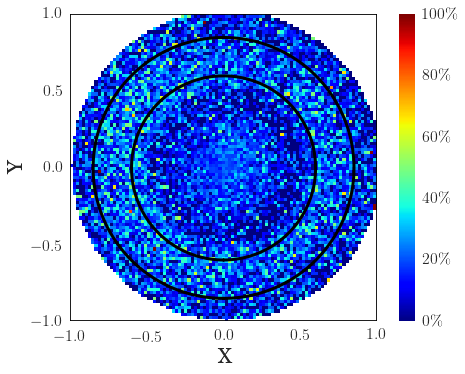

In [19]:
pcol = plt.pcolormesh(x_points, y_points, 100.* map_tool, vmin=0., vmax=100., linewidth=0, cmap="jet")  
pcol.set_rasterized(True)      
pcol.set_edgecolor('face')
pcol.cmap.set_under('white')
pcol.cmap.set_over('white')

cb = plt.colorbar()
cb.ax.set_yticklabels(["$0\%$", "", "$20\%$", "", "$40\%$", "", "$60\%$", "", "$80\%$", "", "$100\%$"], fontsize = 16)
cb.solids.set_rasterized(True)
cb.solids.set_edgecolor("face")   

ax = plt.axes()
ax.set_aspect(1)
theta = np.linspace(-np.pi, np.pi, 200)
plt.plot(0.6 * np.sin(theta), 0.6 * np.cos(theta), 'k', lw=3)
plt.plot(0.85 * np.sin(theta), 0.85 * np.cos(theta), 'k', lw=3)


plt.xlabel("X", fontsize=20)
plt.ylabel("Y", fontsize=20)

plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

plt.axhline(-1, color='k')
plt.axvline(-1, color='k')
plt.axhline(1, color='k')
plt.axvline(1, color='k')

plt.savefig('../figs/fig_strategy_tool.pdf', format='pdf', bbox_inches='tight')

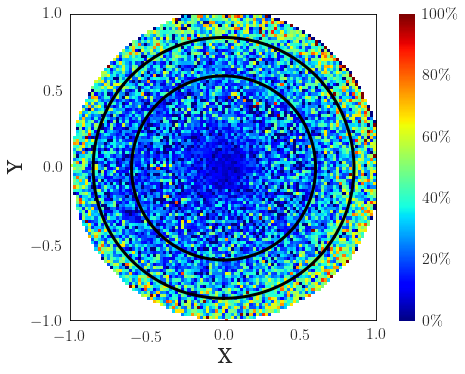

In [20]:
pcol = plt.pcolormesh(x_points, y_points, 100.* map_vocal, vmin=0., vmax=100., linewidth=0, cmap="jet")  
pcol.set_rasterized(True)      
pcol.set_edgecolor('face')
pcol.cmap.set_under('white')
pcol.cmap.set_over('white')

cb = plt.colorbar()
cb.ax.set_yticklabels(["$0\%$", "", "$20\%$", "", "$40\%$", "", "$60\%$", "", "$80\%$", "", "$100\%$"], fontsize = 16)
cb.solids.set_rasterized(True)
cb.solids.set_edgecolor("face")   

ax = plt.axes()
ax.set_aspect(1)
theta = np.linspace(-np.pi, np.pi, 200)
plt.plot(0.6 * np.sin(theta), 0.6 * np.cos(theta), 'k', lw=3)
plt.plot(0.85 * np.sin(theta), 0.85 * np.cos(theta), 'k', lw=3)


plt.xlabel("X", fontsize=20)
plt.ylabel("Y", fontsize=20)

plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

plt.axhline(-1, color='k')
plt.axvline(-1, color='k')
plt.axhline(1, color='k')
plt.axvline(1, color='k')

plt.savefig('../figs/fig_strategy_vocal.pdf', format='pdf', bbox_inches='tight')

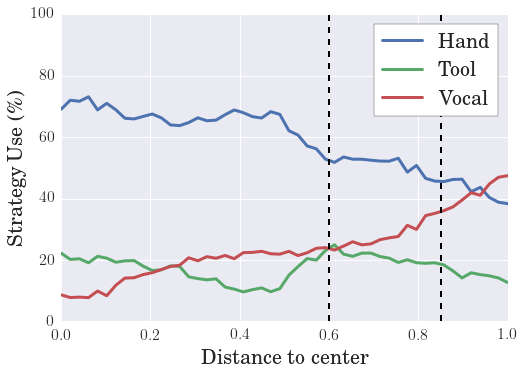

In [10]:
mean_hand = np.zeros(50)
count_hand = np.zeros(50)

for i in range(bins):
    for j in range(bins):
        d = int(np.sqrt((i-bins/2)*(i-bins/2) + (j-bins/2)*(j-bins/2)))
        if d < 50:
            mean_hand[d] += map_hand[i, j]
            count_hand[d] += 1

mean_hand = mean_hand / count_hand

mean_tool = np.zeros(50)
count_tool = np.zeros(50)

for i in range(bins):
    for j in range(bins):
        d = int(np.sqrt((i-bins/2)*(i-bins/2) + (j-bins/2)*(j-bins/2)))
        if d < 50:
            mean_tool[d] += map_tool[i, j]
            count_tool[d] += 1
            
mean_tool = mean_tool / count_tool

mean_vocal = np.zeros(50)
count_vocal = np.zeros(50)

for i in range(bins):
    for j in range(bins):
        d = int(np.sqrt((i-bins/2)*(i-bins/2) + (j-bins/2)*(j-bins/2)))
        if d < 50:
            mean_vocal[d] += map_vocal[i, j]
            count_vocal[d] += 1
            
mean_vocal = mean_vocal / count_vocal

mean_hand /= mean_hand + mean_tool + mean_vocal
mean_tool /= mean_hand + mean_tool + mean_vocal
mean_vocal /= mean_hand + mean_tool + mean_vocal
            
x = np.linspace(0., 1., 50)

plt.plot(x, 100.*mean_hand, lw=3, label="Hand")
plt.plot(x, 100.*mean_tool, lw=3, label="Tool")
plt.plot(x, 100.*mean_vocal, lw=3, label="Vocal")

legend = plt.legend(frameon=True, fontsize=20)
plt.xlabel("Distance to center", fontsize=20)
plt.ylabel("Strategy Use (\%)", fontsize=20)

plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

frame = legend.get_frame()
frame.set_facecolor('1.')
frame.set_edgecolor('0.')
    
plt.plot((0.6, 0.6), (0, 100), 'k--', lw=2)
plt.plot((0.85, 0.85), (0, 100), 'k--', lw=2)


plt.savefig('../figs/fig_strategy.pdf', format='pdf', bbox_inches='tight')